<a href="https://colab.research.google.com/github/jenny12138/KaggleModifiedMNISTChallenge/blob/main/FinalAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Pre-processing Data

1) Loading all of the data into the variables train_X, test_X, and train_y

2) Reshape train_X and test_X to fit the dimensions in the model (see section 3)

3) Apply one hot encoding to convert y labels into R^10 vectors

At the end of pre-processing, the arrays that we will fit into the model and use the model on are: train_X_th, test_X_th, train_y_vec

In [2]:
#Mount this Google Account (Numberrec123)'s Google Drive to this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Import libraries
import csv
import numpy as np
import random
import pandas as pd
from sklearn import preprocessing
import collections
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split 
from PIL import Image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import metrics
import random
from tensorflow import keras
import os
import cv2
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
#First, load the train_y data
with open('/content/drive/My Drive/Data/train_y.csv') as csv_file:
  csv_reader = csv.reader(csv_file)
  train_colnames = next(csv_reader) #Holds the column names
  train_y = list(csv_reader) #Holds the values of the two columns, skips over column names

In [5]:
train_y = np.array(train_y)
train_y = train_y[:, 1]
train_y = train_y.astype(int)

In [6]:
#There are 10 output categories. Apply one-hot-encoding to convert each y label into a R^10 vector
lb = preprocessing.LabelBinarizer()
train_y_vec=lb.fit_transform(train_y) #Applying one-hot-encoding to original labels

In [7]:
#Confirm one hot encoding applied properly
print(type(train_y_vec))
print(train_y_vec.shape)
print(train_y_vec)

<class 'numpy.ndarray'>
(40000, 10)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]]


In [8]:
#Now, loading the train_x and test_y data
train_X = np.load("/content/drive/My Drive/Data/train_x.npy")
test_X = np.load("/content/drive/My Drive/Data/test_x.npy")

In [9]:
train_X = train_X[..., np.newaxis] #Add new axis with value 1 for 1 colour channel (greyscale)
test_X = test_X[..., np.newaxis] #Add new axis with value 1 for 1 colour channel (greyscale)

In [10]:
#Confirm that the dimensions are (#samples, 128, 128, 1)
print(type(train_X))
print(train_X.shape)
print(type(test_X))
print(test_X.shape)

<class 'numpy.ndarray'>
(40000, 128, 128, 1)
<class 'numpy.ndarray'>
(10000, 128, 128, 1)


In [11]:
#Getting rid of the background using binary threshold:
def preprocessing(data):
  res_img = []
  for i in range(len(data)):
        ret,th_img = cv2.threshold(data[i].astype('uint8'),210,255,cv2.THRESH_BINARY)
        res_img.append(th_img)
  res_img = np.array(res_img)
  res_img = res_img[..., np.newaxis]
  return res_img

In [12]:
train_X_th = preprocessing(train_X) #Shape (len, 128, 128, 1): Can be fit into model

In [13]:
test_X_th = preprocessing(test_X)

In [14]:
#Confirm processed train_X_th and train_X_th
print(type(train_X_th))
print(train_X_th.shape)
print(type(test_X_th))
print(test_X_th.shape)

<class 'numpy.ndarray'>
(40000, 128, 128, 1)
<class 'numpy.ndarray'>
(10000, 128, 128, 1)


In [15]:
np.save('/content/drive/My Drive/train_X_th.npy', train_X_th)

In [16]:
np.save('/content/drive/My Drive/test_X_th.npy', test_X_th)

In [17]:
np.save('/content/drive/My Drive/train_y_vec.npy', train_y_vec)

# Part 2: Preview a few images from the unprocessed and processed train_X dataset:

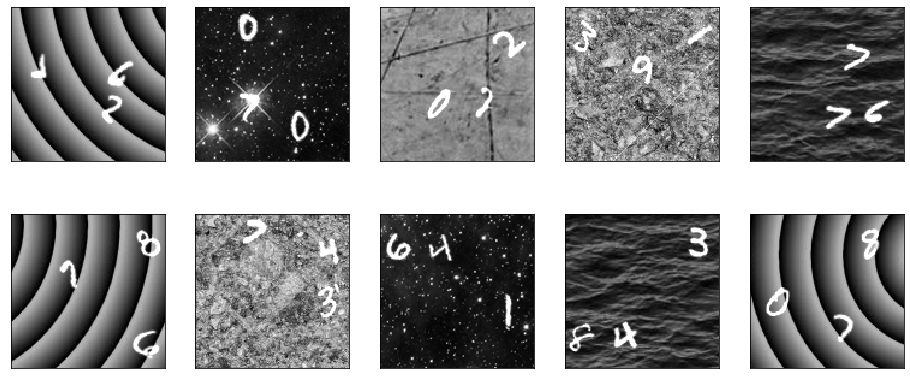

In [18]:
#Unprocessed
plt.figure(figsize=(16,7))
for i in range(10):
    plt.subplot(2,5,1+i)
    two_d = (np.reshape(train_X[i,:,:,0], (128, 128))).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest', cmap=('gray'))
    plt.xticks([]), plt.yticks([])
plt.show()

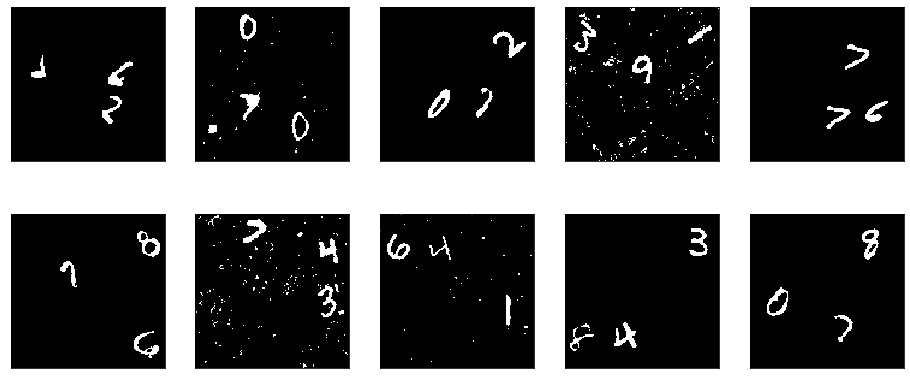

In [19]:
#Processed
plt.figure(figsize=(16,7))
for i in range(10):
    plt.subplot(2,5,1+i)
    two_d = (np.reshape(train_X_th[i,:,:,0], (128, 128))).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest', cmap=('gray'))
    plt.xticks([]), plt.yticks([])
plt.show()

# Part 3: Create Convolutional Neural Network and Train Model


In [20]:
model = tf.keras.Sequential() #Create a sequential model

#Convolutional layer #1
#Use Conv2D as we are processing image
model.add(layers.Conv2D(64, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 1))) #Input size is 128 pixels by 128 pixels, greyscale so 1 color channel
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25)) #Prevents overfitting, hypervariable

#Convolutional layer #2
model.add(layers.Conv2D(128, (3, 3), padding="same", activation="relu")) 
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Convolutional layer #3
model.add(layers.Conv2D(512, (3, 3), padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Convolutional layer #4
model.add(layers.Conv2D(512, (3, 3), padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool2D(pool_size=(2,2))) 
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Flatten the volume to pass through fully connected layer
model.add(layers.Flatten())

#Fully connected layer #1
model.add(layers.Dense(256, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Fully connected layer #2
model.add(layers.Dense(512, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25)) #Prevents overfitting

#Classification result
model.add(layers.Dense(10, activation="softmax")) #10 output classes, using softmax instead of relu because this is the output layer

#We will use the Adam optimizer, and compile our model
optimizer = Adam(learning_rate=0.0005) #Set learning rate to 0.0005
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0

In [21]:
epochs = 15

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy", 
                            save_weights_only=True, mode="max", verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.1, patience=2, min_lr=0.00001, model="auto") #learning rate scheduling, decreases learning rate by 0.1 if doesn't get better for 2 epochs

callbacks = [checkpoint, reduce_lr]

history = model.fit(
    x = train_X_th,
    y = train_y_vec,
    validation_split=0.3,
    epochs=epochs,
    callbacks = callbacks
    )

Epoch 1/15
875/875 [==============================] - ETA: 0s - loss: 2.2874 - accuracy: 0.2046WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0023s vs `on_test_batch_end` time: 0.0154s). Check your callbacks.

Epoch 00001: saving model to model_weights.h5
875/875 [==============================] - 63s 73ms/step - loss: 2.2874 - accuracy: 0.2046 - val_loss: 1.9987 - val_accuracy: 0.2258
Epoch 2/15
875/875 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.2644
Epoch 00002: saving model to model_weights.h5
875/875 [==============================] - 65s 74ms/step - loss: 1.9702 - accuracy: 0.2644 - val_loss: 2.4291 - val_accuracy: 0.2641
Epoch 3/15
875/875 [==============================] - ETA: 0s - loss: 1.5812 - accuracy: 0.4186
Epoch 00003: saving model to model_weights.h5
875/875 [==============================] - 64s 73ms/step - loss: 1.5812 - accuracy: 0.4186 - val_loss: 1.9290 - val_accuracy: 0.4077
Ep

In [22]:
from datetime import datetime

#Just using the date so that we know which model's the latest and we can always go back to the model that performed the best with the handwriting dataset
now = datetime.now()
dt_string = now.strftime("%d.%m.%Y.%H.%M.%S")
model.save("/content/drive/My Drive/my_model.{}".format(dt_string))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/my_model.23.11.2020.15.58.09/assets


In [ ]:
reconstructed_model = keras.models.load_model("/content/drive/My Drive/my_model.19.11.2020.05.26.52") #Change date after my_model to get the model we want

# Part 5: Getting Kaggle submission results

In [23]:
prediction = model.predict(test_X_th)
y_pred = prediction.argmax(axis=-1)
y_pred = y_pred.reshape((1,-1))
y_index = np.arange(len(y_pred[0]))
y_index = y_index.reshape((1, -1))

#Combining index and predictions
output = np.dstack((y_index, y_pred))

In [24]:
print(output)
output = output.reshape(10000,2)
print(output.shape)
print(output)
output = output.astype(int)

[[[   0    7]
  [   1    5]
  [   2    9]
  ...
  [9997    5]
  [9998    3]
  [9999    6]]]
(10000, 2)
[[   0    7]
 [   1    5]
 [   2    9]
 ...
 [9997    5]
 [9998    3]
 [9999    6]]


In [25]:
np.savetxt("/content/drive/My Drive/submission4.csv", output, fmt='%i', delimiter=",")

In [26]:
df = pd.read_csv('/content/drive/My Drive/submission4.csv', header=None)
df.rename(columns={0: 'Id', 1: 'Label'}, inplace=True)
df.to_csv('/content/drive/My Drive/labelled_submission4.csv', index=False) #This contains the file to submit to Kaggle